In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf


2025-12-14 18:41:47.483692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-14 18:41:47.483756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-14 18:41:47.485275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-14 18:41:47.493238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
IMG_SIZE = 256
DATASET_PATH = "../data/"

In [5]:
def rle_decode(rle, shape=(768, 768)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = list(map(int, rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = np.array(starts) - 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')



def preprocess_image_mask(image_path, mask_rles, img_size=IMG_SIZE):
    # Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, [img_size, img_size])
    # Mask
    mask = np.zeros((768, 768), dtype=np.float32)
    for rle in mask_rles:
        if pd.notna(rle):
            mask += rle_decode(rle)
    mask = np.clip(mask, 0, 1)
    mask = tf.image.resize(mask[..., None], [img_size, img_size], method='nearest')

    return img, mask

In [ ]:
mask_df = pd.read_csv(DATASET_PATH+"train_ship_segmentations_v2.csv")
grouped = mask_df.groupby("ImageId")

image_files = sorted(os.listdir(DATASET_PATH+"train_v2"))[:100]
image_paths = [np.array(os.path.join(DATASET_PATH+"train_v2", f)) for f in image_files]

rle_lists = [grouped.get_group(f)["EncodedPixels"].values if f in grouped.groups else [] for f in image_files]
images = []
masks = []
counts = []
for index in range(len(image_paths)):
    image, mask = preprocess_image_mask(image_paths[index], rle_lists[index])
    images.append(image)
    masks.append(mask)
    if str(rle_lists[index][0])=="nan":
        counts.append(0)
    else:
        counts.append(len(rle_lists[index]))

dataset = tf.data.Dataset.from_tensor_slices((images, masks, counts))


In [ ]:

train_dataset, test_dataset = tf.keras.utils.split_dataset(dataset,left_size=0.8, shuffle=True)
train_dataset, val_dataset = tf.keras.utils.split_dataset(train_dataset,left_size=0.8, shuffle=True)

train_dataset_notEmpty = train_dataset.filter(lambda img, mask, count: count > 0)
train_dataset_empty = train_dataset.filter(lambda img, mask, count: count == 0)

notEmpty_len = tf.data.experimental.cardinality(train_dataset_notEmpty).numpy()
train_dataset_empty = train_dataset_empty.take(notEmpty_len)

train_dataset = train_dataset_empty.concatenate(train_dataset_notEmpty)

train_counts = train_dataset.map(lambda img, mask, count: count)
val_counts = val_dataset.map(lambda img, mask, count: count)
test_counts = test_dataset.map(lambda img, mask, count: count)

train_dataset = train_dataset.map(lambda img, mask, count: (img, mask))
val_dataset = val_dataset.map(lambda img, mask, count: (img, mask))
test_dataset = test_dataset.map(lambda img, mask, count: (img, mask))

train_dataset.save("data/dataset/train")
val_dataset.save("data/dataset/val")
test_dataset.save("data/dataset/test")


2025-12-07 18:50:41.599360: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-07 18:50:41.719123: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import layers, Model
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.losses import BinaryCrossentropy


In [ ]:


def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x


def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(f)
    return f, p


def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x



def build_unet():
    inputs = layers.Input((128, 128, 3))

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [ ]:


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)          
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.cast(y_pred_f > 0.5, "float32")
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
bce = BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))

In [14]:
def f2_score_pixel(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.cast(y_pred_f > 0.5, "float32")

    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))

    beta2 = 4.0  # F2 -> beta^2 = 4
    return (1 + beta2) * tp / ((1 + beta2) * tp + beta2 * fn + fp + smooth)


In [26]:
model = build_unet()
model.summary()

model.compile(
    optimizer="adam",
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_score, f2_score_pixel]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_76[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_78[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ conv2d_79[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_80[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 16, 16,    │          0 │ conv2d_81[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_18… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_82[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 8, 8, 512) │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_19… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_84[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_16    │ (None, 16, 16,    │          0 │ conv2d_85[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 16, 16,    │          0 │ up_sampling2d_16

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
checkpoint = ModelCheckpoint(
    "unet_airbus_best.keras",
    monitor="val_loss",
    save_best_only=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
)

callbacks = [checkpoint, reduce_lr, early_stop]

In [19]:
BATCH_SIZE = 32

train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

In [27]:
EPOCHS = 1
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


2025-12-07 18:54:43.303649: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 268435456 exceeds 10% of free system memory.
2025-12-07 18:54:43.412896: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 402653184 exceeds 10% of free system memory.
2025-12-07 18:54:45.707884: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 402653184 exceeds 10% of free system memory.
2025-12-07 18:54:48.798329: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 268435456 exceeds 10% of free system memory.


      1/Unknown 24s 24s/step - dice_coef: 3.8071e-12 - f2_score_pixel: 0.0000e+00 - iou_score: 2.1928e-12 - loss: 1.6951

2025-12-07 18:55:03.436936: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 268435456 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [32]:
from tensorflow.keras.models import load_model
model = load_model(
    "unet_airbus_best.keras",
    compile=False
)


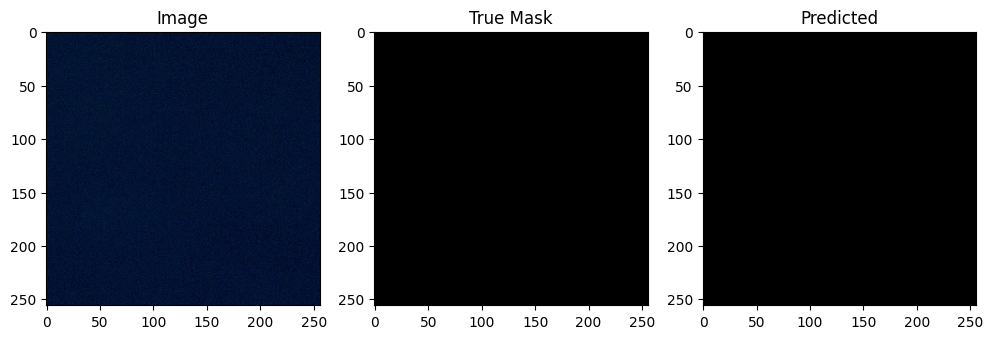

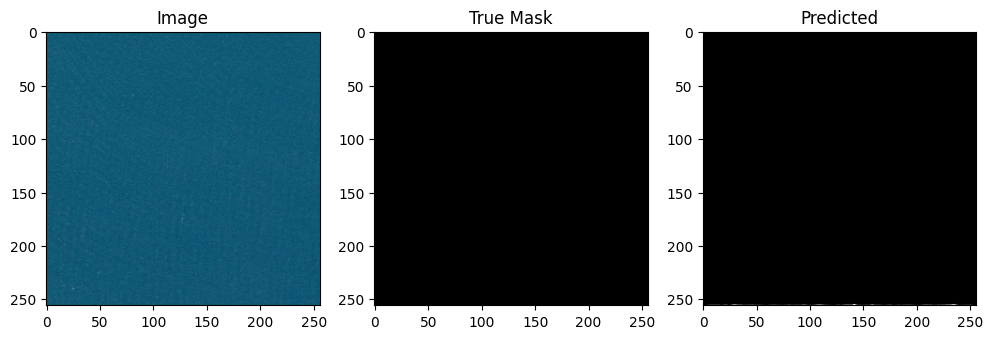

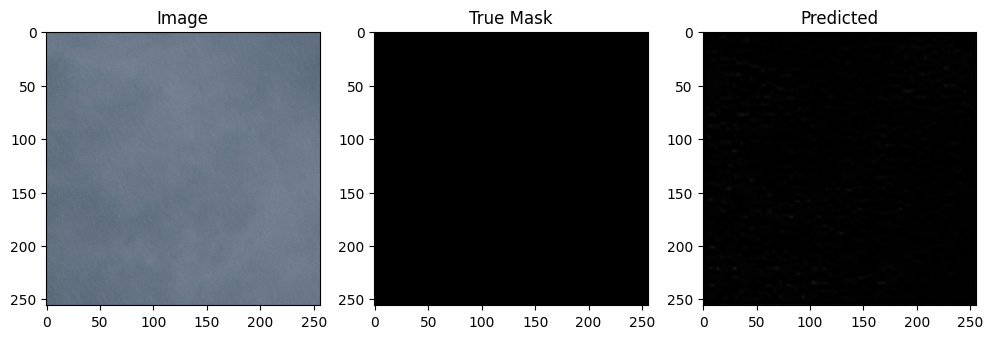

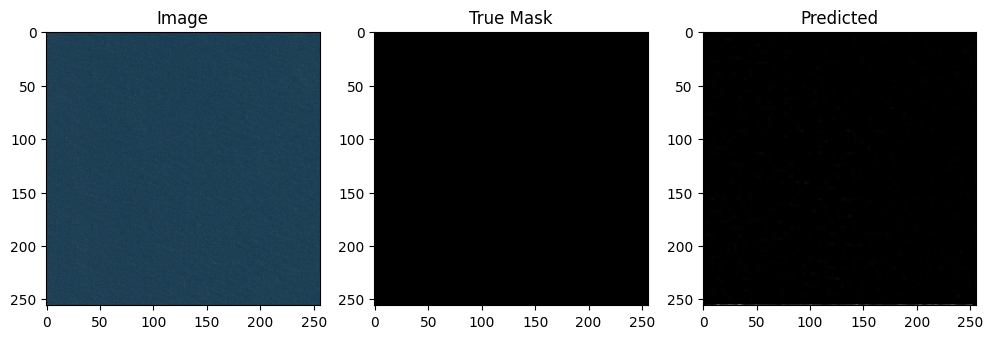

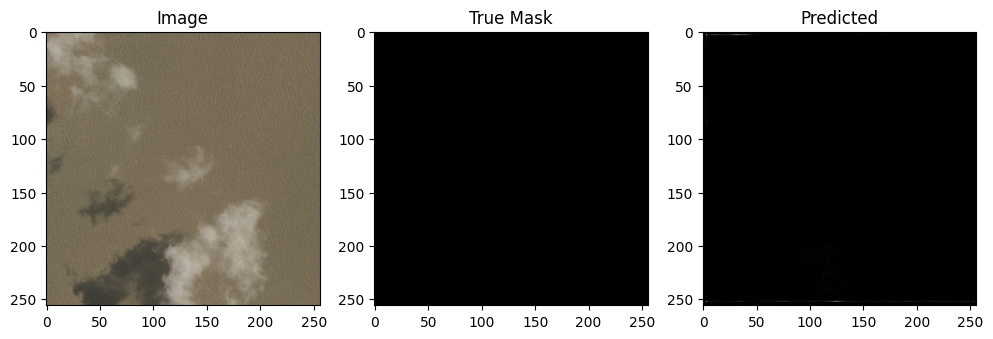

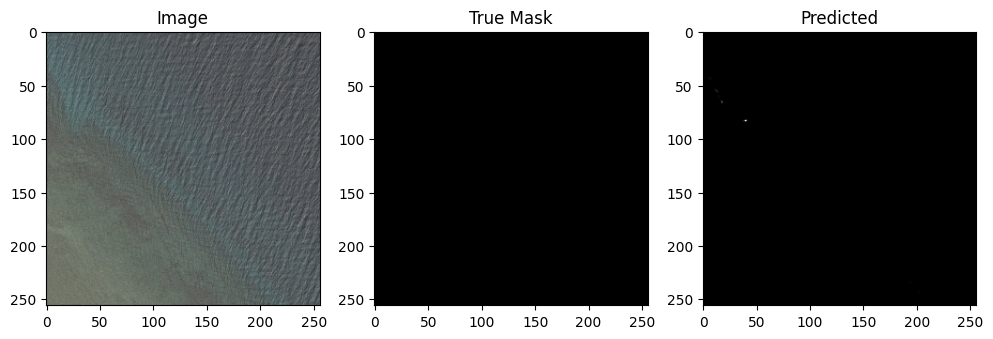

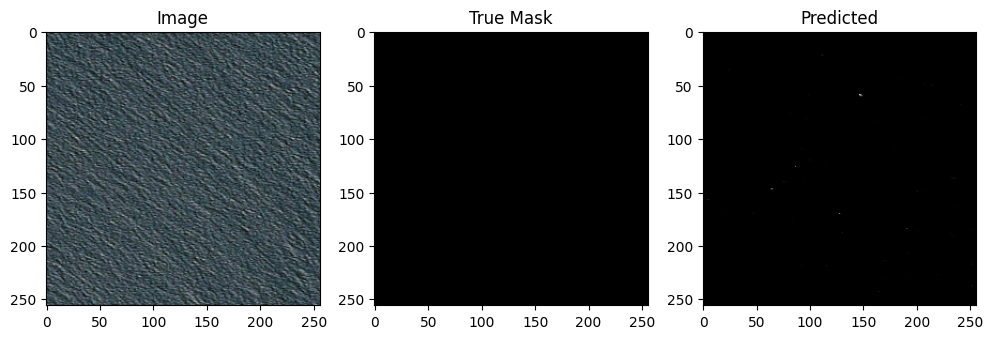

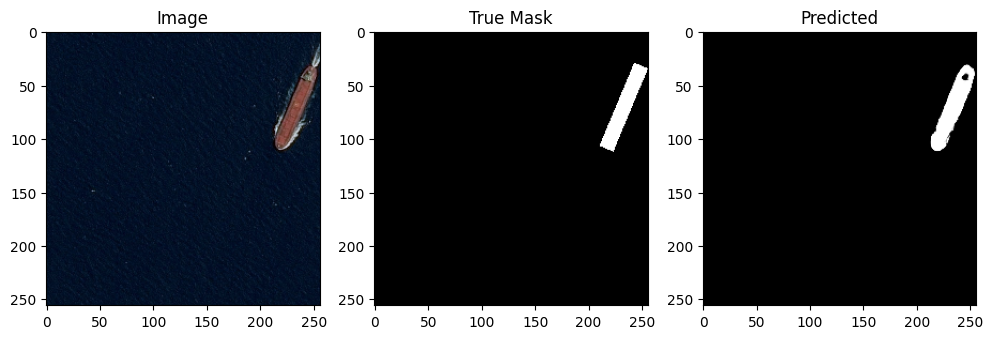

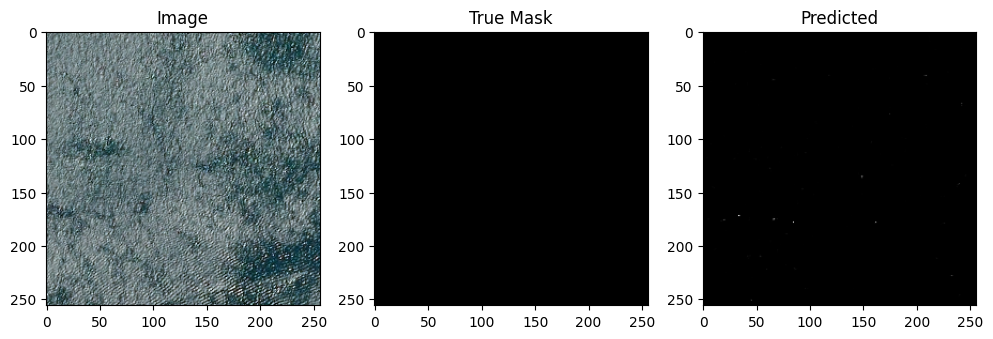

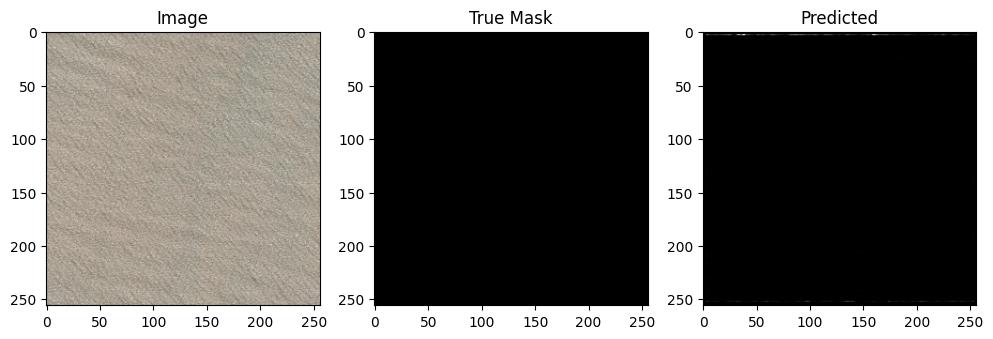

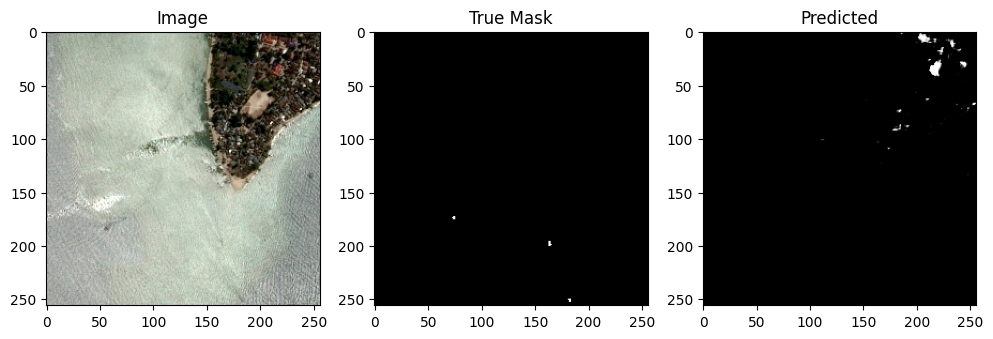

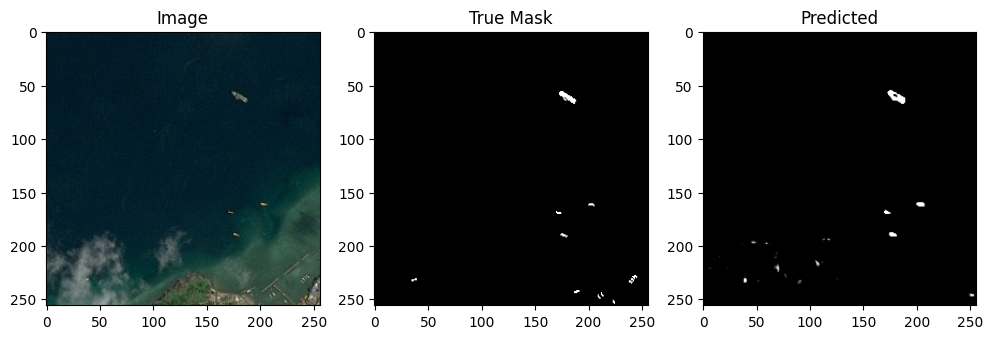

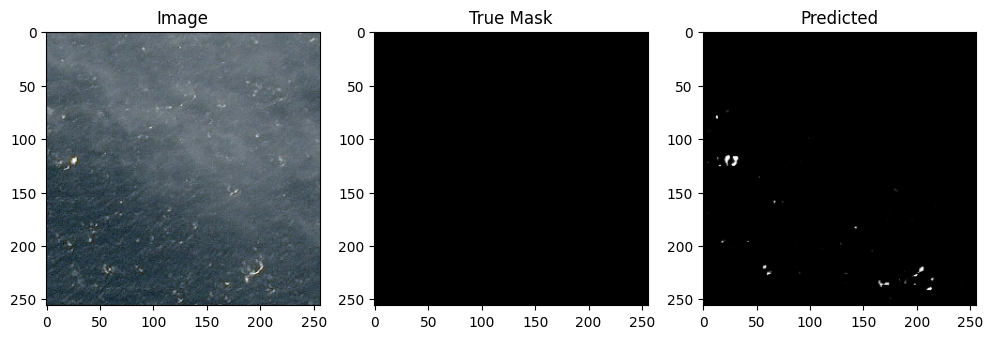

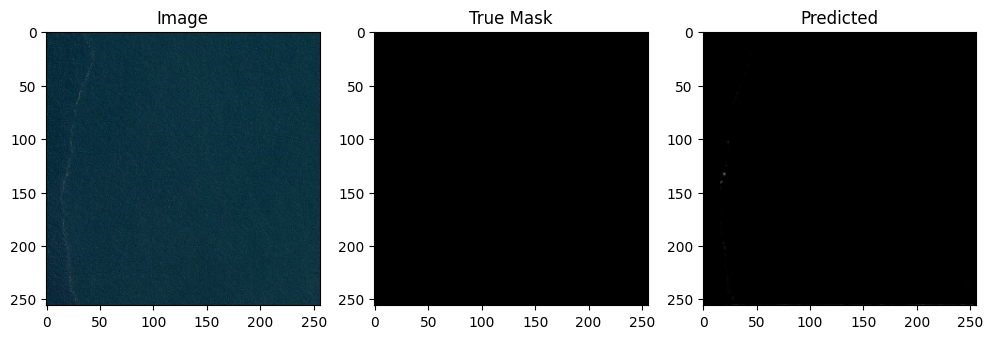

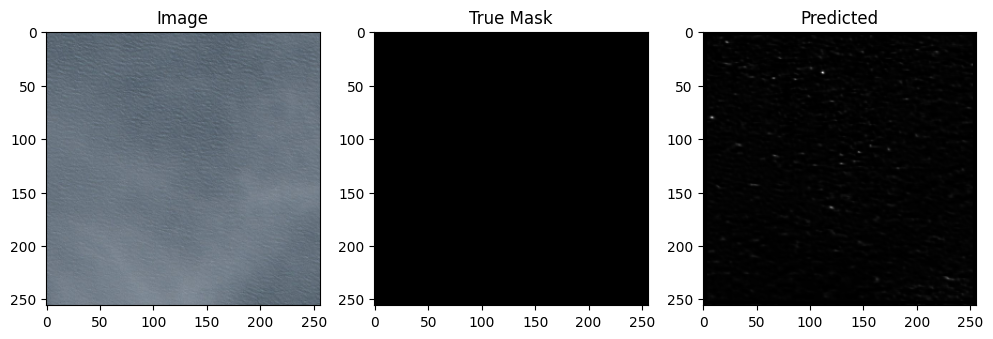

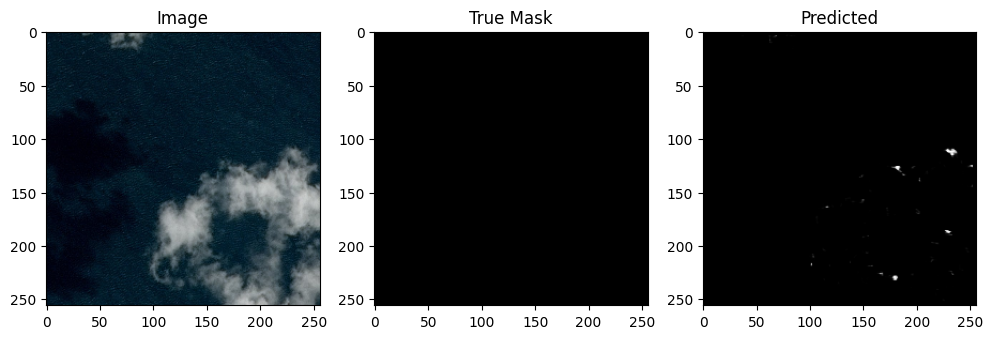

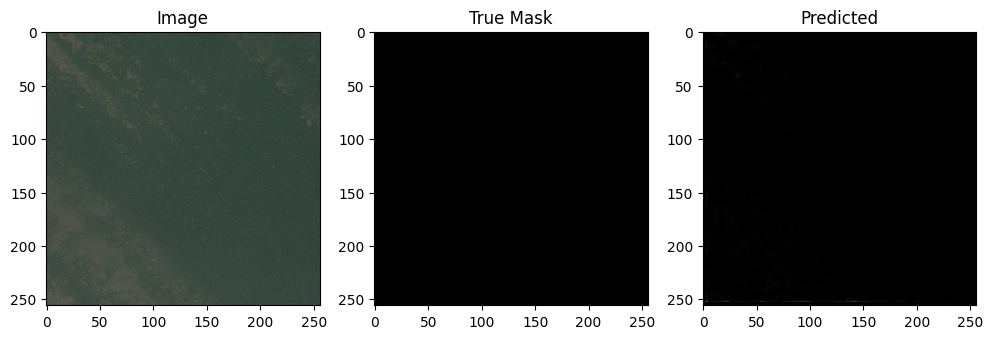

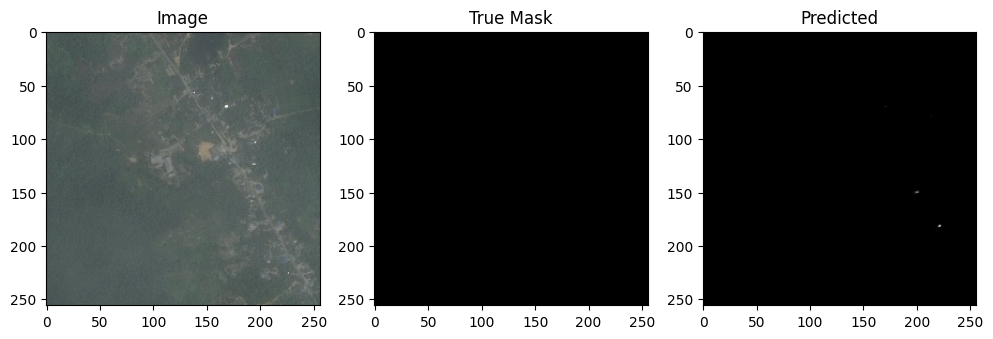

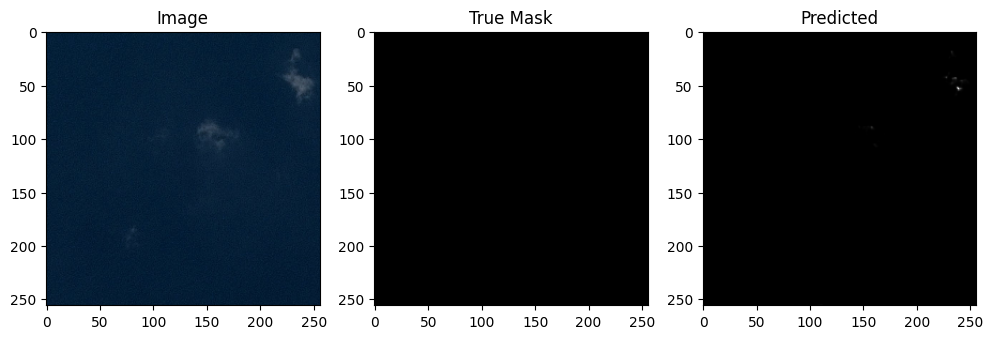

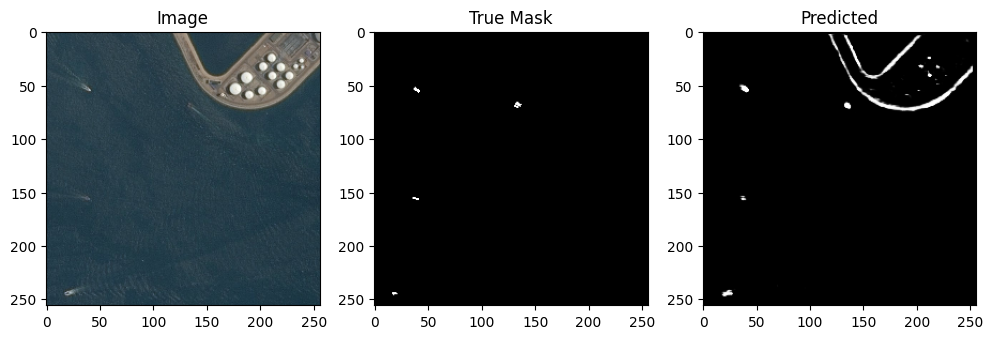

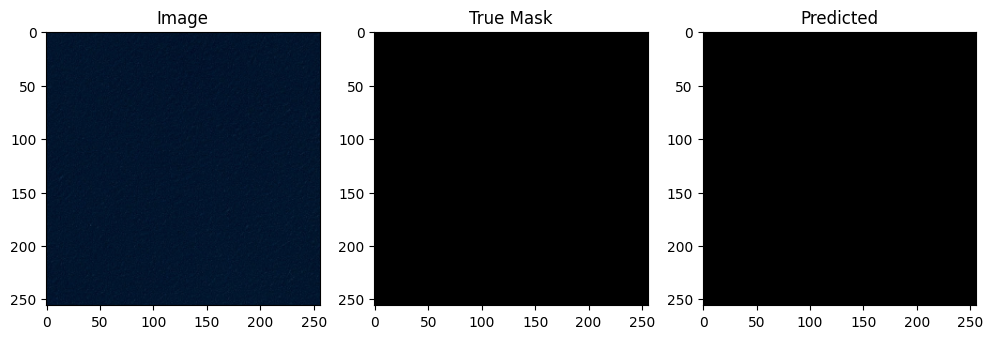

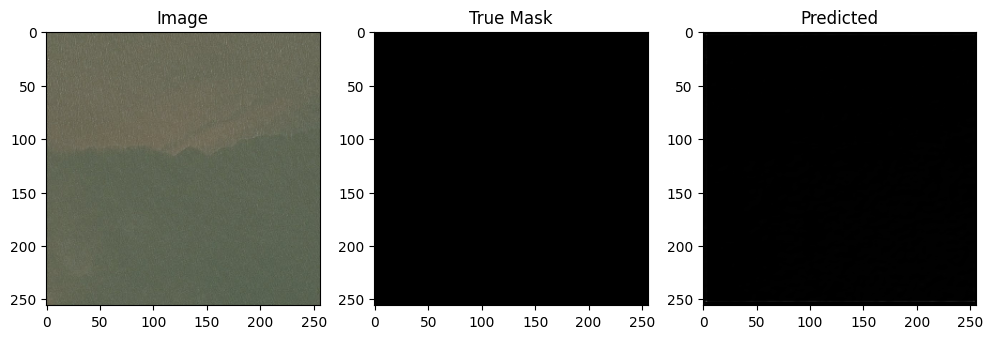

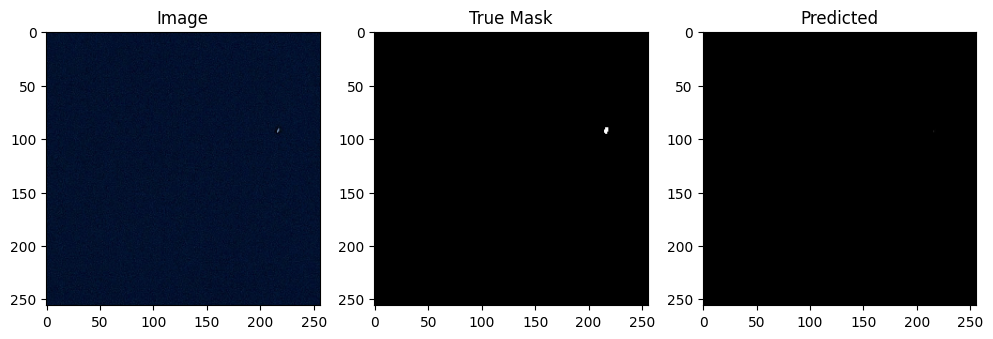

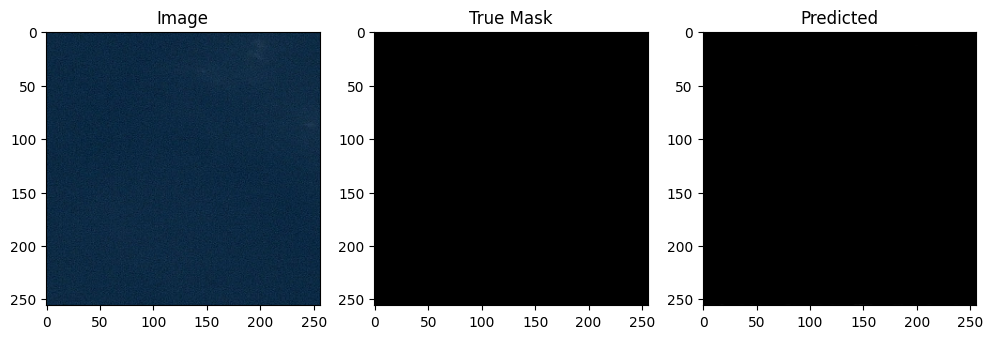

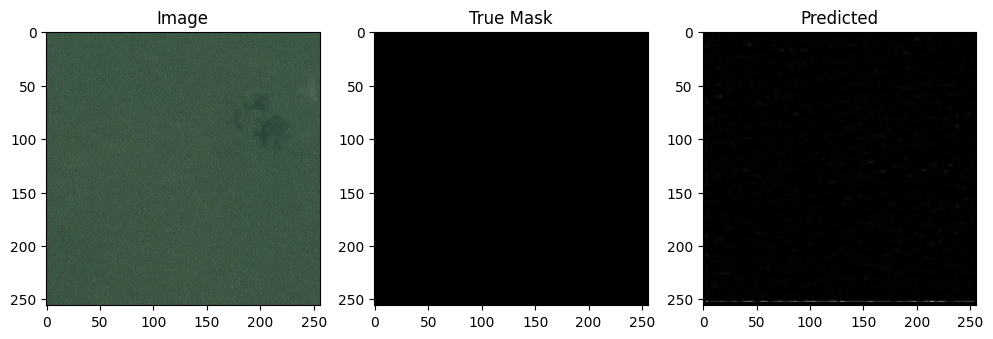

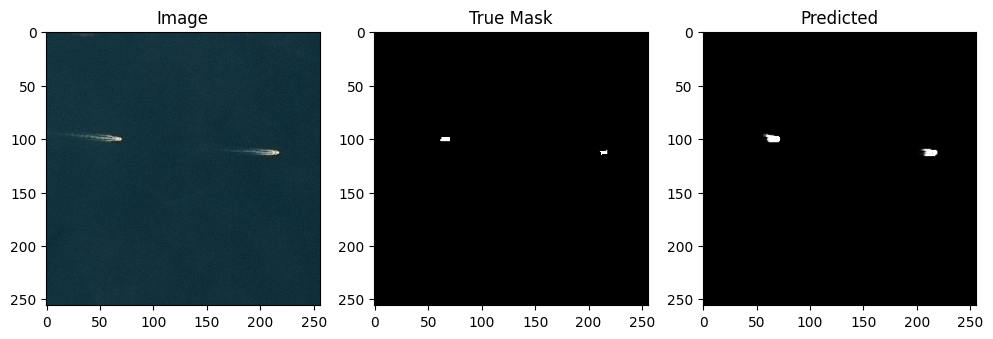

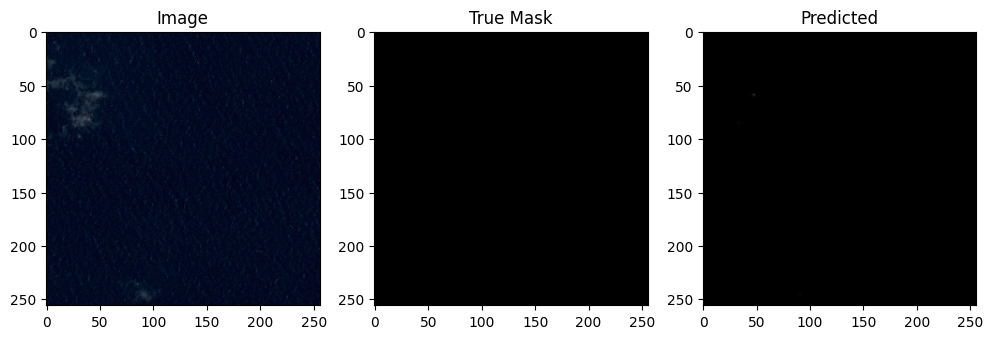

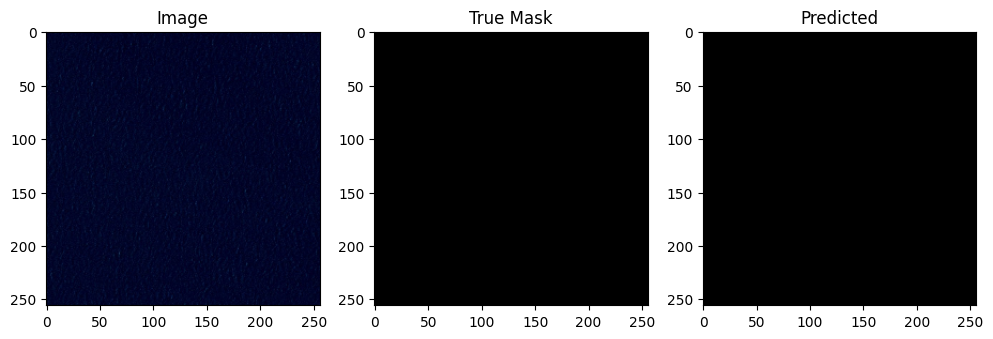

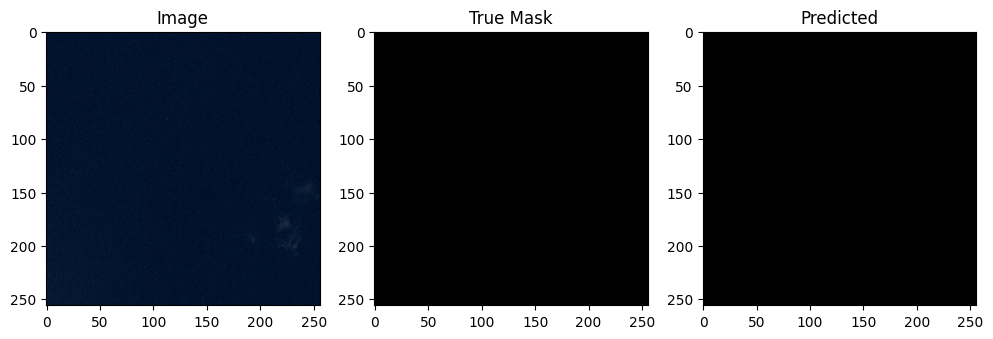

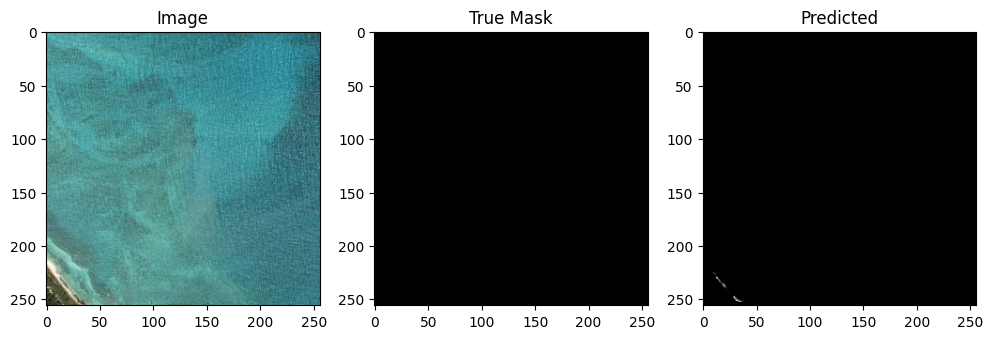

In [37]:
show_predictions_random_batch(val_gen, num_images=30)


# Kiértékelés

In [44]:
import cv2
def iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)

    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return inter / union


def extract_objects(binary_mask):
    binary_mask = binary_mask.astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(binary_mask)

    objects = []
    for label in range(1, num_labels):  # 0 = háttér
        obj_mask = (labels == label)
        objects.append(obj_mask)

    return objects


In [39]:
def f2_score_per_image(gt_mask, pred_mask):
    thresholds = np.arange(0.5, 1.0, 0.05)

    gt_objects   = extract_objects(gt_mask)
    pred_objects = extract_objects(pred_mask)

    # Speciális esetek
    if len(gt_objects) == 0 and len(pred_objects) == 0:
        return 1.0   

    if len(gt_objects) == 0 and len(pred_objects) > 0:
        return 0.0   

    f2_scores = []

    for t in thresholds:
        TP = 0
        FP = 0

        matched_gt = set()

        for pred_obj in pred_objects:
            best_iou = 0.0
            best_gt_idx = None

            # keressük a legjobb GT match-et
            for i, gt_obj in enumerate(gt_objects):
                if i in matched_gt:
                    continue
                iou_val = iou(pred_obj, gt_obj)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_idx = i

            if best_iou >= t and best_gt_idx is not None:
                TP += 1
                matched_gt.add(best_gt_idx)
            else:
                FP += 1

        FN = len(gt_objects) - len(matched_gt)

        beta2 = 4.0  # beta=2 => beta^2 = 4
        denom = (1 + beta2) * TP + beta2 * FN + FP
        if denom == 0:
            f2_t = 0.0
        else:
            f2_t = (1 + beta2) * TP / denom

        f2_scores.append(f2_t)

    return float(np.mean(f2_scores))


In [45]:
def evaluate_dataset_competition_f2(model, test_gen, pred_threshold=0.5):
    all_scores = []

    for batch_idx in range(len(test_gen)):
        X, y = test_gen[batch_idx]            # X: képek, y: GT maszkok
        preds = model.predict(X, verbose=0)   # valószínűségi maszkok

        # Binarizálás
        preds_bin = (preds > pred_threshold).astype(np.uint8)

        batch_size = X.shape[0]

        for i in range(batch_size):
            gt = y[i]
            pr = preds_bin[i]

            # ha (H, W, 1) alakú, lapítsuk 2D-re
            if gt.ndim == 3:
                gt = gt[..., 0]
            if pr.ndim == 3:
                pr = pr[..., 0]

            score = f2_score_per_image(gt > 0.5, pr)  # GT-t is binárissá tesszük
            all_scores.append(score)

    return float(np.mean(all_scores))


In [46]:
test_f2 = evaluate_dataset_competition_f2(model, test_gen, pred_threshold=0.5)
print("Competition-style F2 a test seten:", test_f2)


Competition-style F2 a test seten: 0.6465899388181066
